<a href="https://colab.research.google.com/github/UMA314159/-morning4-Image-Classification/blob/main/WideResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google ColabのDriveモジュールをインポートして、Googleドライブをマウントする許可を実行する。
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#データ処理ライブラリ
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

# 画像処理ライブラリ
import cv2
from PIL import Image

#可視化ライブラリ
import matplotlib.pyplot as plt

#keras
import keras as ks
from keras.utils import np_utils
from keras.initializers import he_normal
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array , array_to_img
from keras import regularizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

#Pythonモジュール
import os
import glob
import re
from collections import OrderedDict

#表示設定
pd.options.display.max_rows = 78
pd.options.display.max_columns = 78

In [3]:
# データの読み込み
train_Y = pd.read_csv('/content/drive/MyDrive/data/train_master.tsv', delimiter='\t')
# ラベル名の削除
train_Y = train_Y.drop('file_name', axis=1)
# カテゴリー変数へ変換
Y = np_utils.to_categorical(train_Y,10)
print(Y.shape)

(5000, 10)


In [4]:
#train_imagesディレクトリ内のデータをリストに格納
train_file = glob.glob('/content/drive/MyDrive/data/train_images/train_images/t*')
len(train_file)

5000

In [5]:
# 番号順に並び替える関数
def sortedStringList(array=[]):
    sortDict=OrderedDict()
    for splitList in array:
        sortDict.update({splitList:[int(x) for x in re.split("(\d+)",splitList)if bool(re.match("\d*",x).group())]})
    return [sortObjKey for sortObjKey,sortObjValue in sorted(sortDict.items(), key=lambda x:x[1])]

sort_file = sortedStringList(train_file)
sort_file[:5]

['/content/drive/MyDrive/data/train_images/train_images/train_0.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_1.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_2.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_3.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_4.jpg']

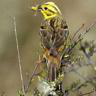

In [6]:
image = load_img(sort_file[0])
image

In [7]:
#画像の前処理
X = []
for img in sort_file:
    #画像ファイルの読み込み
    image = load_img(img)
    #画像ファイルのnumpy化　＋　正規化
    image = img_to_array(image) / 255.0
    #リストへ格納
    X.append(image)
    if len(X) % 1000 == 0:
        print(len(X))


#リストデータをnumpy化
X_np = np.array(X)
print(X_np.shape)
print(X_np.dtype)

1000
2000
3000
4000
5000
(5000, 96, 96, 3)
float32


In [8]:
#データの分割
X_train , X_valid , Y_train , Y_valid = train_test_split(X_np , Y , test_size=0.3 , random_state=1)

#形状を確認
print('Y_train=' , Y_train.shape , 'X_train=' , X_train.shape)
print('Y_valid=' , Y_valid.shape , 'X_valid=' , X_valid.shape)

Y_train= (3500, 10) X_train= (3500, 96, 96, 3)
Y_valid= (1500, 10) X_valid= (1500, 96, 96, 3)


In [9]:
image_gen = ImageDataGenerator(
    rotation_range=45, #45°回転
    horizontal_flip=True, #水平反転
    width_shift_range=0.1,
    height_shift_range=0.1
)

#元となるデータ数を増やす
X_gen = image_gen.flow(X_train, Y_train, batch_size=32)

#画像データを格納
X = []
#ラベルデータを格納
Y = []

for _ in range(10):
    #データ生成
    X_gen_new , y_gen_new = X_gen.__next__()
    #データを結合
    X_train = np.concatenate([X_train , X_gen_new])
    Y_train = np.concatenate([Y_train , y_gen_new])
    X.append(X_train)
    Y.append(Y_train)
    #データサイズを表示
    print(X_train.shape , Y_train.shape)

(3532, 96, 96, 3) (3532, 10)
(3564, 96, 96, 3) (3564, 10)
(3596, 96, 96, 3) (3596, 10)
(3628, 96, 96, 3) (3628, 10)
(3660, 96, 96, 3) (3660, 10)
(3692, 96, 96, 3) (3692, 10)
(3724, 96, 96, 3) (3724, 10)
(3756, 96, 96, 3) (3756, 10)
(3788, 96, 96, 3) (3788, 10)
(3820, 96, 96, 3) (3820, 10)


In [10]:
X_train = X[-1]
Y_train = Y[-1]
print(X_train.shape , Y_train.shape)

(3820, 96, 96, 3) (3820, 10)


In [11]:
#1行5列のグリッド形式で画像をプロットする関数
def plotImages(images_arr):
     fig , axes = plt.subplots(1,5,figsize=(20,20))
     axes = axes.flatten()
     for img , ax in zip( images_arr , axes):
         ax.imshow(img)
         ax.axis('off')
     plt.tight_layout()
     plt.show()

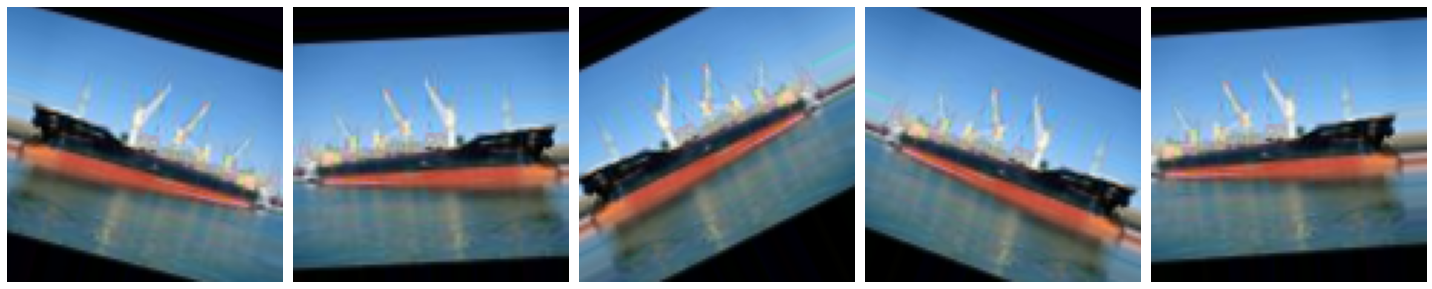

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [12]:
#教師データをまとめる
train_data_gen = image_gen.flow(X_train , Y_train , batch_size=32, shuffle=False)
augmented_images = [train_data_gen[15][0][31] for i in range(5)]

#表示
plotImages(augmented_images)
train_data_gen[15][1][31]

In [13]:
#検証データも教師データと同じ形へ変更
valid_gen = ImageDataGenerator()
valid_data_gen = valid_gen.flow(X_valid , Y_valid , batch_size=32)

In [14]:
class wide_res_block(Model):
    """wide residual block"""
    def __init__(self, out_channels, block_num, layer_num):
        super(wide_res_block, self).__init__(name='block'+'_'+str(block_num)+'_'+str(layer_num))        
        block_name = '_'+str(block_num)+'_'+str(layer_num)

        # shortcutとstrideの設定
        if (layer_num == 0):
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                self._is_change = False
                stride = 1
            else:
                self._is_change = True
                stride = 2
            self.conv_sc = Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False, name='conv_sc'+block_name)
            self.bn_sc = BatchNormalization(name='bn_sc'+block_name)
        else:
            self._is_change = False
            stride = 1

        # 1層目 3×3 畳み込み処理を行います
        self.bn1 = BatchNormalization(name='bn1'+block_name)
        self.act1 = Activation('relu', name='act1'+block_name)
        self.drop1 = Dropout(rate=0.3, name='drop1'+block_name)
        self.conv1 = Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False, name='conv1'+block_name)

        # 2層目 3×3 畳み込み処理を行います
        self.bn2 = BatchNormalization(name='bn2'+block_name)
        self.act2 = Activation('relu', name='act2'+block_name)
        self.drop2 = Dropout(rate=0.3, name='drop2'+block_name)
        self.conv2 = Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False, name='conv2'+block_name)

        self.add = Add(name='add'+block_name)

    def call(self, x):
        out = self.bn1(x)
        out = self.act1(out)
        out = self.drop1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.act2(out)
        out = self.drop2(out)
        out = self.conv2(out)

        if K.int_shape(x) != K.int_shape(out):
            shortcut = self.conv_sc(x)
            shortcut = self.bn_sc(shortcut)
        else:
            shortcut = x

        out = self.add([out, shortcut])
        return out

In [15]:
class WideResNet(Model):
    def __init__(self, depth, k, num_classes=10):
        super().__init__()
        self._layers = []

        # 各ネットワークでのブロックの数
        N = (depth - 4) // 6

        # 入力層
        self._layers += [
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', name='conv_input')
        ]

        # Residualブロック
        self._layers += [wide_res_block(out_channels=16*k, block_num=1, layer_num=i) for i in range(N)]
        self._layers += [wide_res_block(out_channels=32*k, block_num=2, layer_num=i) for i in range(N)]
        self._layers += [wide_res_block(out_channels=64*k, block_num=3, layer_num=i) for i in range(N)]

        # 出力層
        self._layers += [
            BatchNormalization(name='bn_input'),
            Activation('relu', name='act_input'),
            GlobalAveragePooling2D(name='pool_output'),
            Dense(num_classes, activation='softmax', name='output')
        ]

    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

In [16]:
#モデルの構造を確認
model = WideResNet(depth=28, k=10, num_classes=10)
model.build((None, 96, 32, 3))  # build with input shape.
dummy_input = Input(shape=(96, 96, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv_input (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 block_1_0 (wide_res_block)  (None, 96, 96, 160)       257344    
                                                                 
 block_1_1 (wide_res_block)  (None, 96, 96, 160)       462080    
                                                                 
 block_1_2 (wide_res_block)  (None, 96, 96, 160)       462080    
                                                                 
 block_1_3 (wide_res_block)  (None, 96, 96, 160)       462080    
                                                                 
 block_2_0 (wide_res_block)  (None, 48, 48, 320)       143680

In [17]:
#学習率を返す関数を用意
def lr_schedul(epoch):
    x = 0.1
    if epoch >= 60:
        x = 0.1*0.2
    if epoch >= 120:
        x = 0.1*(0.2**2)
    if epoch >= 160:
        x = 0.1(0.2**3)
    return x

In [18]:
lr_decay = LearningRateScheduler(
    lr_schedul,
    verbose=1,
)

sgd = SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
#モデルコンパイル　確率的勾配効果法
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [20]:
#EarlyStoppingの設定
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss' , patience=50)

In [21]:
#モデルの訓練
log = model.fit_generator(train_data_gen,
                 steps_per_epoch=len(X_train) / 64,
                 epochs=1500,
                 callbacks = [callbacks],
                 validation_data=(X_valid , Y_valid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/1500
59/59 [==============================] - 68s 903ms/step - loss: 2.3075 - accuracy: 0.1784 - val_loss: 10.5351 - val_accuracy: 0.0967
Epoch 2/1500
59/59 [==============================] - 52s 877ms/step - loss: 1.9399 - accuracy: 0.2474 - val_loss: 6.9317 - val_accuracy: 0.1627
Epoch 3/1500
59/59 [==============================] - 52s 877ms/step - loss: 1.9047 - accuracy: 0.2781 - val_loss: 2.6742 - val_accuracy: 0.2027
Epoch 4/1500
59/59 [==============================] - 52s 870ms/step - loss: 1.8861 - accuracy: 0.2758 - val_loss: 2.4372 - val_accuracy: 0.2573
Epoch 5/1500
59/59 [==============================] - 52s 870ms/step - loss: 1.8235 - accuracy: 0.3026 - val_loss: 2.8962 - val_accuracy: 0.2207
Epoch 6/1500
59/59 [==============================] - 52s 877ms/step - loss: 1.7985 - accuracy: 0.3168 - val_loss: 2.0391 - val_accuracy: 0.2507
Epoch 7/1500
59/59 [==============================] - 52s 877ms/step - loss: 1.7728 - accuracy: 0.3354 - val_loss: 5.3056 - val_a

In [22]:
image_test_features = np.load('/content/drive/MyDrive/data/test_X_features.npy')

In [23]:
image_test_features = image_test_features.astype('float32')
image_test_features /= 255
image_test_features = image_test_features.reshape(image_test_features.shape[0] , 96 , 96 , 3)

In [24]:
pred_y = model.predict(image_test_features)
pred_y = np.argmax(pred_y , axis=1)

In [25]:
pred_y

array([6, 1, 0, ..., 8, 8, 8])

In [26]:
#sampl_submitデータ
sample = pd.read_table('/content/drive/MyDrive/data/sample_submit.tsv' , index_col = 0 , header=None)
sample[1] = pred_y
sample

,1
0,
test_0.jpg,6
test_1.jpg,1
test_2.jpg,0
test_3.jpg,8
test_4.jpg,5
...,...
test_7995.jpg,9
test_7996.jpg,2
test_7997.jpg,8


In [27]:
sample.to_csv('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/submit/WideResNet.tsv' ,sep='\t' , header=None)